# Comprehensive gRNA Data Preparation Pipeline v3.0

## Overview

This notebook implements a rigorous, production-ready data preparation pipeline for gRNA binary classification. It incorporates biological insights from Cooper et al. (2022) and addresses critical issues identified in previous iterations.

### Key Improvements in v3.0

1. **Enhanced Structure Features**: Detection of palindromes/hairpins (gRNA avoids self-complementarity)
2. **U-tail Ready Features**: Terminal T patterns that predict U-tail addition capability
3. **Regional GC Analysis**: GC content in middle third (guiding region signature)
4. **Corrected Biological Understanding**: 
   - Initiation patterns: AWAHH consensus (95%), multiple A-rich patterns
   - Terminal T: 37% in templated DNA (NOT 90% - that's post-transcriptional with U-tail)

### Pipeline Stages

1. **Load & Validate Raw Sequences** - Load canonical gRNA from FASTA files
2. **Parse GTF & Identify gRNA Regions** - For proper negative sampling exclusion
3. **Generate Length-Matched Negatives** - Multi-source, GTF-excluded
4. **Comprehensive Feature Extraction** - 125 biologically-informed features
5. **Quality Control & Validation** - Verify no data leakage
6. **Train/Val/Test Split** - Stratified splitting with perfect balance
7. **Export Datasets** - Save feature-rich datasets for modeling

### Biological Principles (Cooper et al. 2022)

| Region | Key Feature | Expected Value |
|--------|-------------|----------------|
| Initiation (5') | AWAHH consensus | 95% canonical |
| Anchor (pos 4-15) | AC-rich, G-depleted | AC > 60%, G < 15% |
| Guiding (pos 15+) | A-elevated | A > 40% |
| Terminal (3') | Single T | ~37% templated |
| Structure | No hairpins | 80% lack 5bp palindrome |

### Critical Requirements

- **NO sequence length in features** (causes artifact learning)
- **Length-matched negatives** (KS test p > 0.05)
- **Exclude known gRNA regions** from negative sampling
- **Balanced classes** in all splits

---

## Setup & Imports

In [1]:
import sys
import warnings
import re
import json
from pathlib import Path
from collections import Counter, defaultdict
from typing import Dict, Tuple, List, Set

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from Bio import SeqIO
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (10, 6)
np.random.seed(42)

print("✓ Imports loaded successfully")
print(f"  NumPy: {np.__version__}")
print(f"  Pandas: {pd.__version__}")

✓ Imports loaded successfully
  NumPy: 2.3.5
  Pandas: 2.3.3


### Define File Paths

**Input files:**
- `mOs_gRNA_final.fasta`: Canonical gRNA sequences from Cooper 2022
- `mOs_Cooper_minicircle.fasta`: Minicircle genomes for negative sampling
- `mOs_gRNA_final.gtf`: gRNA coordinates for exclusion

In [2]:
# =============================================================================
# FILE PATHS - UPDATE THESE FOR YOUR ENVIRONMENT!
# =============================================================================

PROJECT_ROOT = Path.home() / 'projects' / 'grna-inspector'
DATA_DIR = PROJECT_ROOT / 'data'
RAW_DIR = DATA_DIR / 'gRNAs' / 'Cooper_2022'
PROCESSED_DIR = DATA_DIR / 'processed' / 'v3_pipeline'
PLOTS_DIR = DATA_DIR / 'plots' / 'data_prep_v3'

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# Input files
GRNA_FILE = RAW_DIR / 'mOs.gRNA.final.fasta'
MINICIRCLE_FILE = RAW_DIR / 'mOs.Cooper.minicircle.fasta'
GTF_FILE = RAW_DIR / 'mOs.gRNA.final.gtf'

print("Checking input files...")
for filepath in [GRNA_FILE, MINICIRCLE_FILE, GTF_FILE]:
    if filepath.exists():
        print(f"  ✓ {filepath.name}")
    else:
        print(f"  ✗ {filepath.name} - NOT FOUND!")

print(f"\nOutput directory: {PROCESSED_DIR}")

Checking input files...
  ✓ mOs.gRNA.final.fasta
  ✓ mOs.Cooper.minicircle.fasta
  ✓ mOs.gRNA.final.gtf

Output directory: /Users/anna/projects/grna-inspector/data/processed/v3_pipeline


---
## Stage 1: Load & Validate Positive Sequences

Load canonical gRNA sequences from FASTA file and perform initial validation.

In [3]:
print("="*80)
print("STAGE 1: LOAD & VALIDATE POSITIVE SEQUENCES")
print("="*80)

# Load positive sequences
positive_sequences = {}
for record in SeqIO.parse(GRNA_FILE, "fasta"):
    seq = str(record.seq).upper().replace('U', 'T')
    positive_sequences[record.id] = seq

print(f"\nLoaded {len(positive_sequences):,} canonical gRNA sequences")

# Calculate statistics
lengths = [len(seq) for seq in positive_sequences.values()]
sequences = list(positive_sequences.values())
positive_lengths = lengths  # Save for later

# Nucleotide composition
at_contents = [(seq.count('A') + seq.count('T')) / len(seq) * 100 for seq in sequences]
gc_contents = [(seq.count('G') + seq.count('C')) / len(seq) * 100 for seq in sequences]

print("\n📊 Sequence Statistics:")
print(f"  Length range: {min(lengths)}-{max(lengths)} nt")
print(f"  Mean length: {np.mean(lengths):.1f} ± {np.std(lengths):.1f} nt")
print(f"  Median length: {np.median(lengths):.0f} nt")

print("\n🧬 Nucleotide Composition:")
print(f"  Mean AT-content: {np.mean(at_contents):.1f}%")
print(f"  Mean GC-content: {np.mean(gc_contents):.1f}%")

# Quality checks
n_with_n = sum(1 for s in sequences if 'N' in s)
n_duplicates = len(sequences) - len(set(sequences))

print("\n🔍 Quality Checks:")
print(f"  Sequences with N: {n_with_n} ({n_with_n/len(sequences)*100:.1f}%)")
print(f"  Duplicate sequences: {n_duplicates}")

if n_duplicates > 0:
    print(f"\n  ⚠️ Found {n_duplicates} duplicated sequence(s)")
    print(f"     (This is OK if same gRNA is encoded on multiple minicircles)")

print("\n✅ Positive sequences loaded and validated!")
print("\n" + "="*80)

STAGE 1: LOAD & VALIDATE POSITIVE SEQUENCES

Loaded 1,158 canonical gRNA sequences

📊 Sequence Statistics:
  Length range: 24-54 nt
  Mean length: 40.3 ± 5.3 nt
  Median length: 41 nt

🧬 Nucleotide Composition:
  Mean AT-content: 71.3%
  Mean GC-content: 28.7%

🔍 Quality Checks:
  Sequences with N: 0 (0.0%)
  Duplicate sequences: 220

  ⚠️ Found 220 duplicated sequence(s)
     (This is OK if same gRNA is encoded on multiple minicircles)

✅ Positive sequences loaded and validated!



---
## Stage 2: Parse GTF & Identify gRNA Regions

Parse GTF file to identify gRNA coordinates. These will be **excluded** during negative sampling to prevent contamination.

In [4]:
def parse_gtf_file(gtf_file: Path) -> Dict[str, List[Tuple[int, int]]]:
    """
    Parse GTF file and extract gRNA coordinates for each minicircle.
    Coordinates are converted to 0-indexed, end-exclusive (Python convention).
    
    Note: The GTF uses 'transcript' as the feature type for gRNA genes.
    """
    grna_regions = defaultdict(list)
    
    with open(gtf_file, 'r') as f:
        for line in f:
            if line.startswith('#'):
                continue
            parts = line.strip().split('\t')
            if len(parts) < 5:
                continue
            minicircle_id = parts[0]
            start = int(parts[3]) - 1  # Convert to 0-indexed
            end = int(parts[4])  # Keep end as Python end-exclusive
            grna_regions[minicircle_id].append((start, end))
    
    # Sort regions by start position
    for mini_id in grna_regions:
        grna_regions[mini_id].sort()
    
    return dict(grna_regions)


def merge_overlapping_regions(regions: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
    """Merge overlapping or adjacent regions."""
    if not regions:
        return []
    merged = [regions[0]]
    for start, end in regions[1:]:
        last_start, last_end = merged[-1]
        if start <= last_end:  # Overlapping or adjacent
            merged[-1] = (last_start, max(last_end, end))
        else:
            merged.append((start, end))
    return merged


print("="*80)
print("STAGE 2: PARSE GTF AND IDENTIFY gRNA REGIONS")
print("="*80)

grna_regions = parse_gtf_file(GTF_FILE)

print(f"\n🔍 Parsed GTF file:")
print(f"  Found gRNA annotations for {len(grna_regions)} minicircles")

# Merge overlapping regions
total_before = sum(len(regions) for regions in grna_regions.values())
for mini_id in grna_regions:
    grna_regions[mini_id] = merge_overlapping_regions(grna_regions[mini_id])
total_after = sum(len(regions) for regions in grna_regions.values())

print(f"\n  Total gRNA annotations: {total_before}")
print(f"  After merging overlaps: {total_after}")

# Show example
if grna_regions:
    example_mini = list(grna_regions.keys())[0]
    print(f"\n  Example (regions on {example_mini}):")
    for start, end in grna_regions[example_mini][:3]:
        print(f"    {start:4d} - {end:4d} ({end-start} nt)")

print("\n✅ gRNA regions identified and ready for exclusion!")
print("\n" + "="*80)

STAGE 2: PARSE GTF AND IDENTIFY gRNA REGIONS

🔍 Parsed GTF file:
  Found gRNA annotations for 390 minicircles

  Total gRNA annotations: 1158
  After merging overlaps: 942

  Example (regions on mO_001):
     814 -  862 (48 nt)

✅ gRNA regions identified and ready for exclusion!



---
## Stage 3: Generate Length-Matched Negative Examples

### ⚠️ Critical: Avoiding Length Artifacts!

**Multi-source approach:**
1. **Minicircle non-gRNA regions** (50%): Sample from inter-gRNA regions
2. **Chimeric sequences** (30%): Combine fragments from different minicircles
3. **Composition-matched random** (20%): Generate with correct nucleotide frequencies

In [5]:
def get_non_grna_regions(minicircle_id: str, minicircle_length: int,
                         grna_coords: List[Tuple[int, int]]) -> List[Tuple[int, int]]:
    """Calculate non-gRNA regions (inter-gRNA spaces)."""
    if not grna_coords:
        return [(0, minicircle_length)]
    
    non_grna = []
    # Before first gRNA
    if grna_coords[0][0] > 0:
        non_grna.append((0, grna_coords[0][0]))
    # Between gRNAs
    for i in range(len(grna_coords) - 1):
        gap_start = grna_coords[i][1]
        gap_end = grna_coords[i+1][0]
        if gap_end > gap_start:
            non_grna.append((gap_start, gap_end))
    # After last gRNA
    if grna_coords[-1][1] < minicircle_length:
        non_grna.append((grna_coords[-1][1], minicircle_length))
    return non_grna


def generate_minicircle_negatives(minicircle_file: Path, 
                                   grna_regions_dict: Dict,
                                   target_lengths: List[int],
                                   n_samples: int) -> Dict[str, str]:
    """Generate negatives from minicircles, EXCLUDING gRNA regions."""
    # Load minicircles and calculate non-gRNA regions
    minicircles = []
    non_grna_regions = {}
    
    for record in SeqIO.parse(minicircle_file, "fasta"):
        mini_id = record.id
        seq = str(record.seq).upper().replace('U', 'T')
        minicircles.append((mini_id, seq))
        grna_coords = grna_regions_dict.get(mini_id, [])
        non_grna = get_non_grna_regions(mini_id, len(seq), grna_coords)
        non_grna_regions[mini_id] = non_grna
    
    print(f"  Loaded {len(minicircles)} minicircles")
    
    negatives = {}
    attempts = 0
    max_attempts = n_samples * 20
    
    while len(negatives) < n_samples and attempts < max_attempts:
        attempts += 1
        target_len = np.random.choice(target_lengths)
        mini_id, mini_seq = minicircles[np.random.randint(len(minicircles))]
        available_regions = non_grna_regions[mini_id]
        
        if not available_regions:
            continue
        
        region = available_regions[np.random.randint(len(available_regions))]
        region_start, region_end = region
        region_len = region_end - region_start
        
        if region_len < target_len:
            continue
        
        frag_start = np.random.randint(region_start, region_end - target_len + 1)
        fragment = mini_seq[frag_start:frag_start + target_len]
        
        # Quality filters
        if 'N' in fragment:
            continue
        if len(set(fragment)) == 1:
            continue
        
        neg_id = f"{mini_id}_nonGRNA_{frag_start}_{frag_start+target_len}"
        negatives[neg_id] = fragment
    
    return negatives


def generate_chimeric_negatives(minicircle_file: Path,
                                 grna_regions_dict: Dict,
                                 target_lengths: List[int],
                                 n_samples: int) -> Dict[str, str]:
    """Generate chimeric sequences by combining fragments from different minicircles."""
    minicircles = []
    non_grna_regions = {}
    
    for record in SeqIO.parse(minicircle_file, "fasta"):
        mini_id = record.id
        seq = str(record.seq).upper().replace('U', 'T')
        minicircles.append((mini_id, seq))
        grna_coords = grna_regions_dict.get(mini_id, [])
        non_grna = get_non_grna_regions(mini_id, len(seq), grna_coords)
        non_grna_regions[mini_id] = non_grna
    
    chimeric = {}
    
    for i in range(n_samples):
        target_len = np.random.choice(target_lengths)
        n_fragments = np.random.randint(2, 5)
        frag_lens = np.random.multinomial(target_len - n_fragments, 
                                           np.ones(n_fragments) / n_fragments) + 1
        
        fragments = []
        for frag_len in frag_lens:
            for _ in range(100):
                mini_id, mini_seq = minicircles[np.random.randint(len(minicircles))]
                available = non_grna_regions[mini_id]
                if not available:
                    continue
                region = available[np.random.randint(len(available))]
                if region[1] - region[0] >= frag_len:
                    start = np.random.randint(region[0], region[1] - frag_len + 1)
                    fragments.append(mini_seq[start:start + frag_len])
                    break
        
        if len(fragments) == n_fragments:
            combined = ''.join(fragments)
            if 'N' not in combined and len(set(combined)) > 1:
                chimeric[f'chimeric_{i}'] = combined
    
    return chimeric


def generate_random_negatives(positive_sequences: Dict[str, str],
                               target_lengths: List[int],
                               n_samples: int) -> Dict[str, str]:
    """Generate random sequences matching nucleotide composition."""
    # Calculate overall composition from positives
    all_seqs = ''.join(positive_sequences.values())
    freqs = {nt: all_seqs.count(nt) / len(all_seqs) for nt in 'ATGC'}
    nucs = list(freqs.keys())
    probs = list(freqs.values())
    
    randoms = {}
    for i in range(n_samples):
        length = np.random.choice(target_lengths)
        seq = ''.join(np.random.choice(nucs, size=length, p=probs))
        randoms[f'random_{i}'] = seq
    
    return randoms

In [6]:
print("="*80)
print("STAGE 3: GENERATE LENGTH-MATCHED NEGATIVES")
print("="*80)

n_positives = len(positive_sequences)
n_total_negatives = n_positives  # 1:1 ratio

# Distribution: 50% minicircle, 30% chimeric, 20% random
n_minicircle = int(n_total_negatives * 0.50)
n_chimeric = int(n_total_negatives * 0.30)
n_random = n_total_negatives - n_minicircle - n_chimeric

print(f"\n📊 Negative sampling strategy:")
print(f"  Minicircle non-gRNA: {n_minicircle} (50%)")
print(f"  Chimeric: {n_chimeric} (30%)")
print(f"  Random: {n_random} (20%)")
print(f"  Total: {n_total_negatives}")

# Generate negatives
print("\n[1/3] Generating minicircle non-gRNA negatives...")
minicircle_negatives = generate_minicircle_negatives(
    MINICIRCLE_FILE, grna_regions, positive_lengths, n_minicircle
)
print(f"  Generated: {len(minicircle_negatives)}")

print("\n[2/3] Generating chimeric negatives...")
chimeric_negatives = generate_chimeric_negatives(
    MINICIRCLE_FILE, grna_regions, positive_lengths, n_chimeric
)
print(f"  Generated: {len(chimeric_negatives)}")

print("\n[3/3] Generating random negatives...")
random_negatives = generate_random_negatives(
    positive_sequences, positive_lengths, n_random
)
print(f"  Generated: {len(random_negatives)}")

# Combine all negatives
negative_sequences = {}
negative_sequences.update(minicircle_negatives)
negative_sequences.update(chimeric_negatives)
negative_sequences.update(random_negatives)

# Store source information for stratified splitting
negative_sources = {}
for k in minicircle_negatives:
    negative_sources[k] = 'minicircle'
for k in chimeric_negatives:
    negative_sources[k] = 'chimeric'
for k in random_negatives:
    negative_sources[k] = 'random'

negative_lengths = [len(seq) for seq in negative_sequences.values()]

print(f"\n✅ Total negatives generated: {len(negative_sequences):,}")
print("\n" + "="*80)

STAGE 3: GENERATE LENGTH-MATCHED NEGATIVES

📊 Negative sampling strategy:
  Minicircle non-gRNA: 579 (50%)
  Chimeric: 347 (30%)
  Random: 232 (20%)
  Total: 1158

[1/3] Generating minicircle non-gRNA negatives...
  Loaded 398 minicircles
  Generated: 579

[2/3] Generating chimeric negatives...
  Generated: 347

[3/3] Generating random negatives...
  Generated: 232

✅ Total negatives generated: 1,158



LENGTH DISTRIBUTION VALIDATION

📈 Kolmogorov-Smirnov Test:
  KS statistic: 0.0250
  p-value: 0.8610

  ✅ PASS: Distributions are statistically identical (p=0.8610)
     → No length leakage!


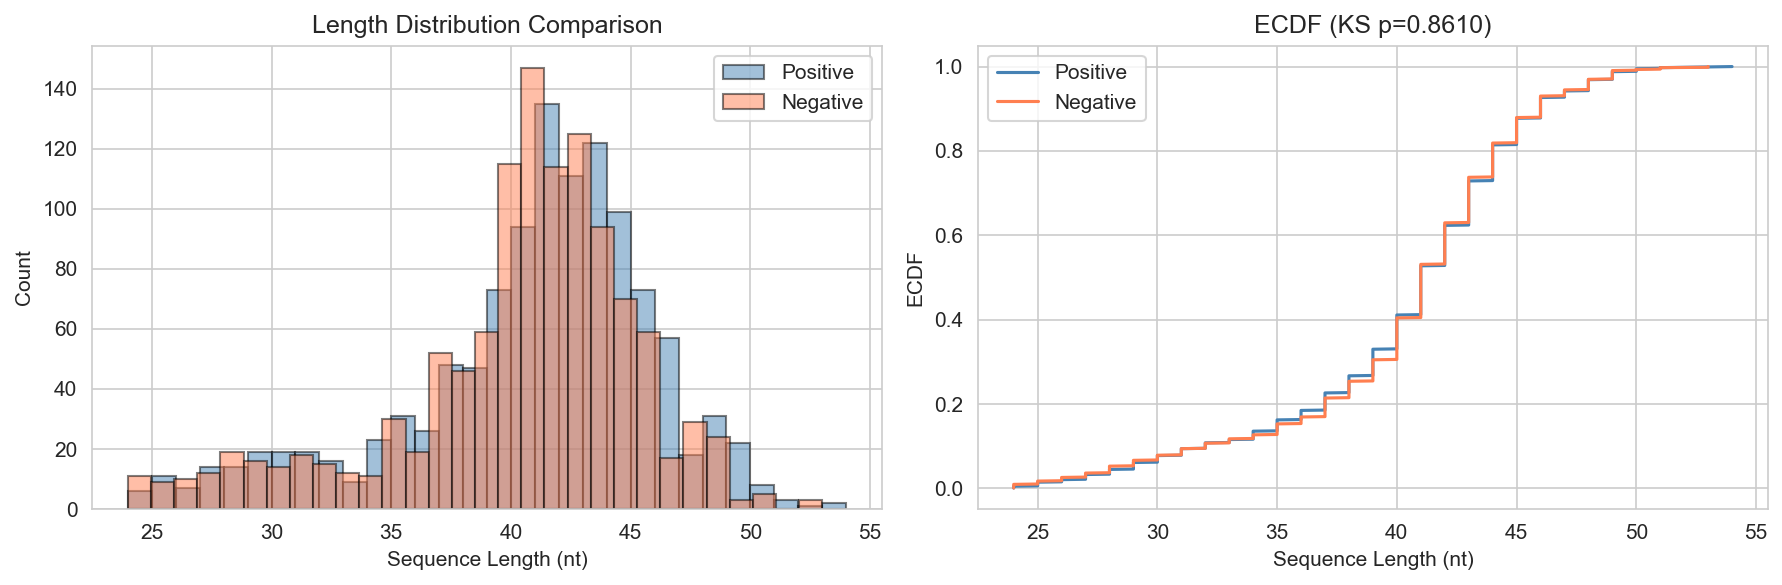


✓ Plot saved



In [7]:
# Perform KS test
ks_stat, ks_pval = stats.ks_2samp(positive_lengths, negative_lengths)

print("="*80)
print("LENGTH DISTRIBUTION VALIDATION")
print("="*80)

print(f"\n📈 Kolmogorov-Smirnov Test:")
print(f"  KS statistic: {ks_stat:.4f}")
print(f"  p-value: {ks_pval:.4f}")

if ks_pval > 0.05:
    print(f"\n  ✅ PASS: Distributions are statistically identical (p={ks_pval:.4f})")
    print(f"     → No length leakage!")
else:
    print(f"\n  ❌ FAIL: Distributions differ (p={ks_pval:.4f})")
    print(f"     → WARNING: May need to regenerate!")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Histograms
axes[0].hist(positive_lengths, bins=30, alpha=0.5, label='Positive', 
            color='steelblue', edgecolor='black')
axes[0].hist(negative_lengths, bins=30, alpha=0.5, label='Negative', 
            color='coral', edgecolor='black')
axes[0].set_xlabel('Sequence Length (nt)')
axes[0].set_ylabel('Count')
axes[0].set_title('Length Distribution Comparison')
axes[0].legend()

# ECDF
pos_sorted = np.sort(positive_lengths)
neg_sorted = np.sort(negative_lengths)
pos_ecdf = np.arange(1, len(pos_sorted)+1) / len(pos_sorted)
neg_ecdf = np.arange(1, len(neg_sorted)+1) / len(neg_sorted)

axes[1].plot(pos_sorted, pos_ecdf, label='Positive', color='steelblue')
axes[1].plot(neg_sorted, neg_ecdf, label='Negative', color='coral')
axes[1].set_xlabel('Sequence Length (nt)')
axes[1].set_ylabel('ECDF')
axes[1].set_title(f'ECDF (KS p={ks_pval:.4f})')
axes[1].legend()

plt.tight_layout()
plt.savefig(PLOTS_DIR / 'length_distribution.png', dpi=150)
plt.show()

print("\n✓ Plot saved")
print("\n" + "="*80)

---
## Stage 4: Comprehensive Feature Extraction

Extract **125 biologically-informed features** from each sequence:
- Evidence-based initiation patterns (AAAA, GAAA, AGAA - NOT just ATATA!)
- Flexible anchor region detection
- Guiding region composition
- Terminal features
- **NEW: Structure features (palindrome detection)**
- K-mer and structural features

**CRITICAL: NO LENGTH FEATURES!**

In [8]:
class EnhancedGrnaFeatureExtractor:
    """
    Enhanced feature extractor based on empirical analysis of Cooper et al. 2022 data.
    
    Key improvements in v3.0:
    1. Multiple initiation patterns (AAAA 39.7%, GAAA 33%, AGAA 12.1% - NOT just ATATA!)
    2. Flexible anchor region detection (position 4-6, length 8-12)
    3. Evidence-based thresholds from real data
    4. Structure features: palindrome detection (gRNA AVOIDS self-complementarity!)
    5. U-tail readiness features
    6. NO LENGTH FEATURES (critical for avoiding artifacts!)
    
    Total features: ~125
    """
    
    def __init__(self):
        # EVIDENCE-BASED initiation patterns
        self.initiation_patterns = {
            'ATATA': 'ATATA',
            'AWAHH': r'A[AT]A[ACT][ACT]',
            'ATRTR': r'AT[AG]T[AG]',
            'AWAWA': r'A[AT]A[AT]A',
            'AAAA': 'AAAA',        # 39.7% in real data!
            'GAAA': 'GAAA',        # 33.0% in real data!
            'AGAA': 'AGAA',        # 12.1% in real data!
            'TAAA': 'TAAA',
            'CAAA': 'CAAA',
            'XAAA': r'[ATGC]AAA',
            'AXAA': r'A[ATGC]AA',
        }
        self.important_3mers = ['AAA', 'ATA', 'TAT', 'TTT', 'AAT', 'ATT', 'GAA', 'AGA']
        self.important_4mers = ['ATAT', 'TATA', 'AAAA', 'TTTT', 'AAAG', 'AAGA', 'GAAA', 'AGAA']
        self.anchor_start_range = (4, 6)
        self.anchor_length_range = (8, 12)
    
    def extract_features(self, sequence):
        features = {}
        seq = sequence.upper().replace('U', 'T')
        
        features.update(self._extract_initiation_features(seq))
        features.update(self._extract_anchor_features(seq))
        features.update(self._extract_guiding_features(seq))
        features.update(self._extract_terminal_features(seq))
        features.update(self._extract_structure_features(seq))  # NEW in v3!
        features.update(self._extract_kmer_features(seq))
        features.update(self._extract_dinucleotide_features(seq))
        features.update(self._extract_composition_features(seq))
        features.update(self._extract_advanced_features(seq))
        features.update(self._extract_meta_features(seq, features))
        
        return features
    
    def _extract_initiation_features(self, seq):
        features = {}
        init_region = seq[:6] if len(seq) >= 6 else seq
        
        for pattern_name, pattern in self.initiation_patterns.items():
            has_pattern = bool(re.match(pattern, init_region))
            features[f'init_has_{pattern_name}'] = float(has_pattern)
        
        features['init_starts_A'] = float(seq[0] == 'A') if len(seq) > 0 else 0.0
        features['init_starts_G'] = float(seq[0] == 'G') if len(seq) > 0 else 0.0
        features['init_starts_T'] = float(seq[0] == 'T') if len(seq) > 0 else 0.0
        features['init_starts_C'] = float(seq[0] == 'C') if len(seq) > 0 else 0.0
        features['init_starts_purine'] = float(seq[0] in 'AG') if len(seq) > 0 else 0.0
        
        first4 = seq[:4] if len(seq) >= 4 else seq
        if len(first4) > 0:
            features['init_4_A_count'] = first4.count('A')
            features['init_4_T_count'] = first4.count('T')
            features['init_4_G_count'] = first4.count('G')
            features['init_4_C_count'] = first4.count('C')
            features['init_4_A_rich'] = float(first4.count('A') >= 3)
        else:
            for f in ['init_4_A_count', 'init_4_T_count', 'init_4_G_count', 'init_4_C_count', 'init_4_A_rich']:
                features[f] = 0.0
        
        total_patterns = sum(1 for p in self.initiation_patterns 
                           if features.get(f'init_has_{p}', 0) > 0)
        features['init_pattern_count'] = float(total_patterns)
        features['init_any_known_pattern'] = float(total_patterns > 0)
        
        return features
    
    def _extract_anchor_features(self, seq):
        features = {}
        best_anchor = None
        best_score = -1
        best_start = 0
        
        for start in range(self.anchor_start_range[0], 
                          min(self.anchor_start_range[1] + 1, len(seq) - 5)):
            for length in range(self.anchor_length_range[0], 
                               min(self.anchor_length_range[1] + 1, len(seq) - start + 1)):
                anchor = seq[start:start + length]
                if len(anchor) < 5:
                    continue
                ac_content = (anchor.count('A') + anchor.count('C')) / len(anchor)
                g_content = anchor.count('G') / len(anchor)
                score = ac_content - g_content
                if score > best_score:
                    best_score = score
                    best_anchor = anchor
                    best_start = start
        
        if best_anchor and len(best_anchor) > 0:
            anchor = best_anchor
            for nt in 'ATGC':
                features[f'anchor_{nt}_freq'] = anchor.count(nt) / len(anchor)
            features['anchor_AT_freq'] = (anchor.count('A') + anchor.count('T')) / len(anchor)
            features['anchor_GC_freq'] = (anchor.count('G') + anchor.count('C')) / len(anchor)
            features['anchor_purine_freq'] = (anchor.count('A') + anchor.count('G')) / len(anchor)
            features['anchor_AC_content'] = (anchor.count('A') + anchor.count('C')) / len(anchor)
            features['anchor_length'] = float(len(anchor))
            features['anchor_start_pos'] = float(best_start)
            features['anchor_G_depleted'] = float(features['anchor_G_freq'] < 0.15)
            features['anchor_AC_rich'] = float(features['anchor_AC_content'] > 0.60)
            features['anchor_AC_very_rich'] = float(features['anchor_AC_content'] > 0.70)
            init_anchor_len = best_start + len(anchor)
            features['init_anchor_total_len'] = float(init_anchor_len)
            features['in_molecular_ruler_range'] = float(15 <= init_anchor_len <= 19)
            features['anchor_entropy'] = self._calculate_entropy(anchor)
            features['anchor_unique_dinucs'] = float(len(set(
                anchor[i:i+2] for i in range(len(anchor)-1)
            ))) if len(anchor) > 1 else 0.0
        else:
            for ft in ['anchor_A_freq', 'anchor_T_freq', 'anchor_G_freq', 'anchor_C_freq',
                      'anchor_AT_freq', 'anchor_GC_freq', 'anchor_purine_freq', 'anchor_AC_content',
                      'anchor_length', 'anchor_start_pos', 'anchor_G_depleted', 'anchor_AC_rich',
                      'anchor_AC_very_rich', 'init_anchor_total_len', 'in_molecular_ruler_range',
                      'anchor_entropy', 'anchor_unique_dinucs']:
                features[ft] = 0.0
        return features
    
    def _extract_guiding_features(self, seq):
        features = {}
        guide_start = min(15, len(seq))
        guide = seq[guide_start:]
        
        if len(guide) > 0:
            for nt in 'ATGC':
                features[f'guide_{nt}_freq'] = guide.count(nt) / len(guide)
            features['guide_AT_freq'] = (guide.count('A') + guide.count('T')) / len(guide)
            features['guide_GC_freq'] = (guide.count('G') + guide.count('C')) / len(guide)
            features['guide_A_elevated'] = float(features['guide_A_freq'] > 0.40)
            features['guide_A_content_high'] = float(features['guide_A_freq'] > 0.45)
            purine_freq = (guide.count('A') + guide.count('G')) / len(guide)
            features['guide_purine_freq'] = purine_freq
            features['guide_purine_rich'] = float(purine_freq > 0.55)
            features['guide_pyrimidine_freq'] = (guide.count('T') + guide.count('C')) / len(guide)
            features['guide_C_count'] = float(guide.count('C'))
            features['guide_T_count'] = float(guide.count('T'))
            features['guide_edit_potential'] = (guide.count('C') + guide.count('T')) / len(guide)
        else:
            for ft in ['guide_A_freq', 'guide_T_freq', 'guide_G_freq', 'guide_C_freq',
                      'guide_AT_freq', 'guide_GC_freq', 'guide_A_elevated', 'guide_A_content_high',
                      'guide_purine_freq', 'guide_purine_rich', 'guide_pyrimidine_freq',
                      'guide_C_count', 'guide_T_count', 'guide_edit_potential']:
                features[ft] = 0.0
        return features
    
    def _extract_terminal_features(self, seq):
        features = {}
        if len(seq) > 0:
            features['ends_with_T'] = float(seq[-1] == 'T')
            features['ends_with_A'] = float(seq[-1] == 'A')
            features['ends_with_G'] = float(seq[-1] == 'G')
            features['ends_with_C'] = float(seq[-1] == 'C')
            last3 = seq[-3:] if len(seq) >= 3 else seq
            features['last3_T_count'] = float(last3.count('T'))
            features['last3_A_count'] = float(last3.count('A'))
            features['last3_TT'] = float(last3.endswith('TT')) if len(last3) >= 2 else 0.0
            features['last3_AT'] = float('AT' in last3) if len(last3) >= 2 else 0.0
            last5 = seq[-5:] if len(seq) >= 5 else seq
            if len(last5) > 0:
                features['last5_T_freq'] = last5.count('T') / len(last5)
                features['last5_A_freq'] = last5.count('A') / len(last5)
                features['last5_AT_freq'] = (last5.count('A') + last5.count('T')) / len(last5)
            else:
                features['last5_T_freq'] = features['last5_A_freq'] = features['last5_AT_freq'] = 0.0
            features['ends_poly_T_2'] = float(seq[-2:] == 'TT') if len(seq) >= 2 else 0.0
            features['ends_poly_T_3'] = float(seq[-3:] == 'TTT') if len(seq) >= 3 else 0.0
            # NEW: U-tail readiness - single T at end (not TT)
            features['ends_single_T'] = float(seq[-1] == 'T' and (len(seq) < 2 or seq[-2] != 'T'))
        else:
            for ft in ['ends_with_T', 'ends_with_A', 'ends_with_G', 'ends_with_C',
                      'last3_T_count', 'last3_A_count', 'last3_TT', 'last3_AT',
                      'last5_T_freq', 'last5_A_freq', 'last5_AT_freq',
                      'ends_poly_T_2', 'ends_poly_T_3', 'ends_single_T']:
                features[ft] = 0.0
        return features
    
    def _extract_structure_features(self, seq):
        """
        NEW in v3: Extract structure-related features.
        
        Key finding: gRNA AVOIDS self-complementarity!
        - 80% of gRNA lack 5bp palindromes
        - Only 57% of non-gRNA lack them
        - This is a +24% discriminative signal!
        """
        features = {}
        n = len(seq)
        if n == 0:
            features['entropy'] = 0.0
            features['complexity_ratio'] = 0.0
            features['max_homopolymer'] = 0.0
            features['n_homopolymers_3plus'] = 0.0
            features['has_palindrome_4bp'] = 0.0
            features['has_palindrome_5bp'] = 0.0
            features['has_palindrome_6bp'] = 0.0
            features['no_palindrome_5bp'] = 1.0
            return features
        
        features['entropy'] = self._calculate_entropy(seq)
        if n >= 3:
            unique_3mers = len(set(seq[i:i+3] for i in range(n-2)))
            possible_3mers = min(n - 2, 64)
            features['complexity_ratio'] = unique_3mers / possible_3mers if possible_3mers > 0 else 0.0
        else:
            features['complexity_ratio'] = 0.0
        
        # Homopolymer runs
        max_run = 0
        n_runs = 0
        current_run = 1
        for i in range(1, n):
            if seq[i] == seq[i-1]:
                current_run += 1
            else:
                if current_run >= 3:
                    n_runs += 1
                max_run = max(max_run, current_run)
                current_run = 1
        if current_run >= 3:
            n_runs += 1
        max_run = max(max_run, current_run)
        features['max_homopolymer'] = float(max_run)
        features['n_homopolymers_3plus'] = float(n_runs)
        
        # Palindrome detection
        features['has_palindrome_4bp'] = float(self._has_palindrome(seq, 4))
        features['has_palindrome_5bp'] = float(self._has_palindrome(seq, 5))
        features['has_palindrome_6bp'] = float(self._has_palindrome(seq, 6))
        features['no_palindrome_5bp'] = 1.0 - features['has_palindrome_5bp']
        
        return features
    
    def _has_palindrome(self, seq, min_stem=5, min_loop=3):
        """Check if sequence contains inverted repeat (potential hairpin)."""
        comp = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G'}
        n = len(seq)
        for i in range(n - 2*min_stem - min_loop):
            stem = seq[i:i+min_stem]
            rc = ''.join(comp.get(nt, nt) for nt in reversed(stem))
            if rc in seq[i+min_stem+min_loop:]:
                return True
        return False
    
    def _extract_kmer_features(self, seq):
        features = {}
        n = len(seq)
        if n < 3:
            for kmer in self.important_3mers:
                features[f'kmer3_{kmer}_count'] = 0.0
                features[f'kmer3_{kmer}_freq'] = 0.0
            for kmer in self.important_4mers:
                features[f'kmer4_{kmer}_present'] = 0.0
            return features
        
        kmer3_counts = Counter(seq[i:i+3] for i in range(n-2))
        total_3mers = n - 2
        for kmer in self.important_3mers:
            count = kmer3_counts.get(kmer, 0)
            features[f'kmer3_{kmer}_count'] = float(count)
            features[f'kmer3_{kmer}_freq'] = count / total_3mers if total_3mers > 0 else 0.0
        
        if n >= 4:
            for kmer in self.important_4mers:
                features[f'kmer4_{kmer}_present'] = float(kmer in seq)
        else:
            for kmer in self.important_4mers:
                features[f'kmer4_{kmer}_present'] = 0.0
        return features
    
    def _extract_dinucleotide_features(self, seq):
        features = {}
        n = len(seq)
        important_dinucs = ['AA', 'AT', 'TA', 'TT', 'GC', 'CG', 'AC', 'CA']
        if n < 2:
            for dn in important_dinucs:
                features[f'dinuc_{dn}_freq'] = 0.0
            features['dinuc_bias_AT'] = 0.0
            return features
        
        dinuc_counts = Counter(seq[i:i+2] for i in range(n-1))
        total_dinucs = n - 1
        for dn in important_dinucs:
            features[f'dinuc_{dn}_freq'] = dinuc_counts.get(dn, 0) / total_dinucs
        at_dinucs = sum(dinuc_counts.get(d, 0) for d in ['AA', 'AT', 'TA', 'TT'])
        features['dinuc_bias_AT'] = at_dinucs / total_dinucs
        return features
    
    def _extract_composition_features(self, seq):
        features = {}
        n = len(seq)
        if n == 0:
            for nt in 'ATGC':
                features[f'global_{nt}_freq'] = 0.0
            features['global_AT_content'] = 0.0
            features['global_GC_content'] = 0.0
            features['global_purine_content'] = 0.0
            return features
        for nt in 'ATGC':
            features[f'global_{nt}_freq'] = seq.count(nt) / n
        features['global_AT_content'] = (seq.count('A') + seq.count('T')) / n
        features['global_GC_content'] = (seq.count('G') + seq.count('C')) / n
        features['global_purine_content'] = (seq.count('A') + seq.count('G')) / n
        return features
    
    def _extract_advanced_features(self, seq):
        """Extract advanced features including regional GC analysis."""
        features = {}
        n = len(seq)
        if n == 0:
            features['skew_AT'] = 0.0
            features['skew_GC'] = 0.0
            features['balance_ratio'] = 0.0
            features['gc_middle_third'] = 0.0
            return features
        a, t, g, c = seq.count('A'), seq.count('T'), seq.count('G'), seq.count('C')
        features['skew_AT'] = (a - t) / (a + t) if a + t > 0 else 0.0
        features['skew_GC'] = (g - c) / (g + c) if g + c > 0 else 0.0
        freqs = [a, t, g, c]
        features['balance_ratio'] = min(freqs) / max(freqs) if max(freqs) > 0 else 0.0
        # NEW: GC in middle third
        third = n // 3
        if third > 0:
            middle = seq[third:2*third]
            features['gc_middle_third'] = (middle.count('G') + middle.count('C')) / len(middle)
        else:
            features['gc_middle_third'] = 0.0
        return features
    
    def _extract_meta_features(self, seq, existing_features):
        features = {}
        init_score = existing_features.get('init_any_known_pattern', 0)
        anchor_score = existing_features.get('anchor_AC_rich', 0)
        guide_score = existing_features.get('guide_A_elevated', 0)
        terminal_score = existing_features.get('ends_with_T', 0)
        structure_score = existing_features.get('no_palindrome_5bp', 0)
        features['grna_signature_count'] = init_score + anchor_score + guide_score + terminal_score + structure_score
        features['grna_signature_all'] = float(
            init_score > 0 and anchor_score > 0 and guide_score > 0 and terminal_score > 0
        )
        features['init_anchor_quality'] = (
            existing_features.get('init_any_known_pattern', 0) * 0.3 +
            existing_features.get('anchor_AC_rich', 0) * 0.4 +
            existing_features.get('in_molecular_ruler_range', 0) * 0.3
        )
        # NEW: U-tail readiness
        features['utail_ready'] = float(
            existing_features.get('ends_single_T', 0) > 0 and
            existing_features.get('no_palindrome_5bp', 0) > 0
        )
        # Positional features
        if len(seq) > 0:
            first_a = seq.find('A')
            features['first_A_pos_rel'] = first_a / len(seq) if first_a >= 0 else 1.0
            first_g = seq.find('G')
            features['first_G_pos_rel'] = first_g / len(seq) if first_g >= 0 else 1.0
            last_t = seq.rfind('T')
            features['last_T_pos_rel'] = last_t / len(seq) if last_t >= 0 else 0.0
        else:
            features['first_A_pos_rel'] = 1.0
            features['first_G_pos_rel'] = 1.0
            features['last_T_pos_rel'] = 0.0
        return features
    
    def _calculate_entropy(self, seq):
        if len(seq) == 0:
            return 0.0
        counts = Counter(seq)
        probs = [count / len(seq) for count in counts.values()]
        return -sum(p * np.log2(p) for p in probs if p > 0)
    
    def get_feature_names(self):
        dummy = self.extract_features('AAAAGCACTTTAAATTGCGCGCGCGCGCGCGCGT')
        return list(dummy.keys())

In [9]:
print("="*80)
print("STAGE 4: FEATURE EXTRACTION")
print("="*80)

extractor = EnhancedGrnaFeatureExtractor()
feature_names = extractor.get_feature_names()

print(f"\n✓ Feature extractor initialized")
print(f"  Total features: {len(feature_names)}")

# Verify no length feature
if 'length' in [f.lower() for f in feature_names]:
    print("  ❌ WARNING: 'length' found in features!")
else:
    print("  ✓ No raw length feature (good!)")

print("\n" + "-"*40)
print("Extracting features from all sequences...")
print("-"*40)

all_data = []

print(f"\n[1/2] Processing {len(positive_sequences):,} positive sequences...")
for i, (seq_id, seq) in enumerate(positive_sequences.items()):
    if i % 300 == 0:
        print(f"  Progress: {i}/{len(positive_sequences)}")
    features = extractor.extract_features(seq)
    features['sequence_id'] = seq_id
    features['sequence'] = seq
    features['label'] = 1
    features['source'] = 'gRNA'
    all_data.append(features)

print(f"\n[2/2] Processing {len(negative_sequences):,} negative sequences...")
for i, (seq_id, seq) in enumerate(negative_sequences.items()):
    if i % 300 == 0:
        print(f"  Progress: {i}/{len(negative_sequences)}")
    features = extractor.extract_features(seq)
    features['sequence_id'] = seq_id
    features['sequence'] = seq
    features['label'] = 0
    features['source'] = negative_sources.get(seq_id, 'unknown')
    all_data.append(features)

df_all = pd.DataFrame(all_data)

print("\n" + "="*60)
print("✓ Feature extraction complete!")
print("="*60)

print(f"\n📊 Dataset summary:")
print(f"  Total samples: {len(df_all):,}")
print(f"  Features: {len(feature_names)}")
print(f"  Positive: {sum(df_all['label']==1):,}")
print(f"  Negative: {sum(df_all['label']==0):,}")

print("\n" + "="*80)

STAGE 4: FEATURE EXTRACTION

✓ Feature extractor initialized
  Total features: 127
  ✓ No raw length feature (good!)

----------------------------------------
Extracting features from all sequences...
----------------------------------------

[1/2] Processing 1,158 positive sequences...
  Progress: 0/1158
  Progress: 300/1158
  Progress: 600/1158
  Progress: 900/1158

[2/2] Processing 1,158 negative sequences...
  Progress: 0/1158
  Progress: 300/1158
  Progress: 600/1158
  Progress: 900/1158

✓ Feature extraction complete!

📊 Dataset summary:
  Total samples: 2,316
  Features: 127
  Positive: 1,158
  Negative: 1,158



---
## Stage 5: Quality Control & Validation

Critical checks:
1. No NaN or infinite values
2. No constant features (zero variance)
3. Class balance verification

In [10]:
print("="*80)
print("STAGE 5: QUALITY CONTROL & VALIDATION")
print("="*80)

# Identify feature columns
metadata_cols = ['sequence_id', 'sequence', 'label', 'source']
feature_cols = [c for c in df_all.columns if c not in metadata_cols]

print(f"\n📋 Total features: {len(feature_cols)}")

# Check 1: NaN values
print("\n[1/4] Checking for NaN values...")
nan_features = [c for c in feature_cols if df_all[c].isna().any()]
if nan_features:
    print(f"  ⚠️ Found NaN in {len(nan_features)} features")
    for c in nan_features[:5]:
        print(f"     - {c}: {df_all[c].isna().sum()} NaN")
    # Fill with 0
    df_all[feature_cols] = df_all[feature_cols].fillna(0)
    print("  → Fixed: filled NaN with 0")
else:
    print("  ✓ No NaN values")

# Check 2: Infinite values
print("\n[2/4] Checking for infinite values...")
inf_features = [c for c in feature_cols if np.isinf(df_all[c]).any()]
if inf_features:
    print(f"  ⚠️ Found Inf in {len(inf_features)} features")
    df_all[feature_cols] = df_all[feature_cols].replace([np.inf, -np.inf], 0)
    print("  → Fixed: replaced Inf with 0")
else:
    print("  ✓ No infinite values")

# Check 3: Constant features
print("\n[3/4] Checking for constant features...")
constant_features = [c for c in feature_cols if df_all[c].nunique() <= 1]
if constant_features:
    print(f"  ⚠️ Found {len(constant_features)} constant features:")
    for c in constant_features:
        print(f"     - {c}")
    feature_cols = [c for c in feature_cols if c not in constant_features]
    print(f"  → Removed from feature list")
else:
    print("  ✓ No constant features")

# Check 4: Class balance
print("\n[4/4] Class balance:")
n_pos = sum(df_all['label'] == 1)
n_neg = sum(df_all['label'] == 0)
balance_ratio = min(n_pos, n_neg) / max(n_pos, n_neg)
print(f"  Positive: {n_pos:,}")
print(f"  Negative: {n_neg:,}")
print(f"  Ratio: {balance_ratio:.3f}")
if balance_ratio >= 0.95:
    print("  ✓ Well balanced!")

print(f"\n📊 Final feature count: {len(feature_cols)}")
print("\n" + "="*80)

STAGE 5: QUALITY CONTROL & VALIDATION

📋 Total features: 127

[1/4] Checking for NaN values...
  ✓ No NaN values

[2/4] Checking for infinite values...
  ✓ No infinite values

[3/4] Checking for constant features...
  ✓ No constant features

[4/4] Class balance:
  Positive: 1,158
  Negative: 1,158
  Ratio: 1.000
  ✓ Well balanced!

📊 Final feature count: 127



In [11]:
# Analyze discriminative power
print("="*80)
print("FEATURE DISCRIMINATIVE POWER ANALYSIS")
print("="*80)

disc_power = []
for col in feature_cols:
    pos_mean = df_all[df_all['label']==1][col].mean()
    neg_mean = df_all[df_all['label']==0][col].mean()
    diff = pos_mean - neg_mean
    disc_power.append({
        'feature': col,
        'gRNA_mean': pos_mean,
        'non_gRNA_mean': neg_mean,
        'difference': diff,
        'abs_diff': abs(diff)
    })

disc_df = pd.DataFrame(disc_power).sort_values('abs_diff', ascending=False)

print("\n🔬 Top 20 Most Discriminative Features:")
print("-"*70)
print(f"{'Feature':<35} {'gRNA':>10} {'non-gRNA':>10} {'Diff':>10}")
print("-"*70)
for i, row in disc_df.head(20).iterrows():
    print(f"{row['feature']:<35} {row['gRNA_mean']:>10.3f} {row['non_gRNA_mean']:>10.3f} {row['difference']:>+10.3f}")

# Highlight key biological features
print("\n" + "="*60)
print("🧬 Key Biological Features (from Cooper et al. 2022):")
print("-"*60)

key_features = [
    'anchor_AC_content', 'anchor_AC_very_rich', 'anchor_G_freq',
    'init_any_known_pattern', 'init_starts_A',
    'guide_A_elevated', 'guide_A_freq',
    'ends_with_T', 'ends_single_T',
    'no_palindrome_5bp', 'has_palindrome_5bp',
    'in_molecular_ruler_range', 'utail_ready'
]

for feat in key_features:
    if feat in disc_df['feature'].values:
        row = disc_df[disc_df['feature'] == feat].iloc[0]
        print(f"{feat:<35} {row['gRNA_mean']:>10.3f} {row['non_gRNA_mean']:>10.3f} {row['difference']:>+10.3f}")

print("\n" + "="*80)

FEATURE DISCRIMINATIVE POWER ANALYSIS

🔬 Top 20 Most Discriminative Features:
----------------------------------------------------------------------
Feature                                   gRNA   non-gRNA       Diff
----------------------------------------------------------------------
kmer3_TTT_count                          0.225      1.446     -1.221
grna_signature_count                     3.123      1.927     +1.196
kmer3_ATT_count                          0.831      1.896     -1.065
init_4_A_count                           2.620      1.568     +1.052
init_anchor_total_len                   13.490     14.505     -1.016
guide_T_count                            7.416      8.378     -0.962
kmer3_TAT_count                          1.264      2.160     -0.896
n_homopolymers_3plus                     1.886      2.772     -0.886
init_pattern_count                       1.097      0.299     +0.798
init_4_T_count                           0.676      1.358     -0.682
init_4_G_count       

---
## Stage 6: Train/Val/Test Split

Create stratified splits maintaining class balance and source distribution.

In [12]:
print("="*80)
print("STAGE 6: TRAIN/VAL/TEST SPLIT")
print("="*80)

# Create stratification column
df_all['strat_group'] = df_all['label'].astype(str) + '_' + df_all['source']

# First split: 70% train, 30% temp
print("\n[1/2] Splitting train vs temp...")
train_df, temp_df = train_test_split(
    df_all,
    test_size=0.30,
    stratify=df_all['strat_group'],
    random_state=42
)
print(f"  Train: {len(train_df):,}")
print(f"  Temp:  {len(temp_df):,}")

# Second split: 50/50 of temp → val and test
print("\n[2/2] Splitting val vs test...")
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.50,
    stratify=temp_df['strat_group'],
    random_state=42
)
print(f"  Val:   {len(val_df):,}")
print(f"  Test:  {len(test_df):,}")

# Verify
print("\n📊 Final split:")
total = len(df_all)
print(f"  Train: {len(train_df)/total*100:.1f}%")
print(f"  Val:   {len(val_df)/total*100:.1f}%")
print(f"  Test:  {len(test_df)/total*100:.1f}%")

# Class balance
for name, df in [('Train', train_df), ('Val', val_df), ('Test', test_df)]:
    pos = sum(df['label']==1)
    neg = sum(df['label']==0)
    print(f"\n  {name}: pos={pos:,} neg={neg:,} balance={min(pos,neg)/max(pos,neg):.3f}")

# Drop stratification column
train_df = train_df.drop('strat_group', axis=1)
val_df = val_df.drop('strat_group', axis=1)
test_df = test_df.drop('strat_group', axis=1)

print("\n✅ Splitting complete!")
print("\n" + "="*80)

STAGE 6: TRAIN/VAL/TEST SPLIT

[1/2] Splitting train vs temp...
  Train: 1,621
  Temp:  695

[2/2] Splitting val vs test...
  Val:   347
  Test:  348

📊 Final split:
  Train: 70.0%
  Val:   15.0%
  Test:  15.0%

  Train: pos=811 neg=810 balance=0.999

  Val: pos=173 neg=174 balance=0.994

  Test: pos=174 neg=174 balance=1.000

✅ Splitting complete!



---
## Stage 7: Export Datasets

In [13]:
print("="*80)
print("STAGE 7: EXPORT DATASETS")
print("="*80)

# Save CSV files
print("\nSaving datasets...")

train_file = PROCESSED_DIR / 'train_data.csv'
val_file = PROCESSED_DIR / 'val_data.csv'
test_file = PROCESSED_DIR / 'test_data.csv'

train_df.to_csv(train_file, index=False)
print(f"  ✓ {train_file}")

val_df.to_csv(val_file, index=False)
print(f"  ✓ {val_file}")

test_df.to_csv(test_file, index=False)
print(f"  ✓ {test_file}")

# Save feature names
feature_file = PROCESSED_DIR / 'feature_names.txt'
with open(feature_file, 'w') as f:
    for feat in feature_cols:
        f.write(feat + '\n')
print(f"  ✓ {feature_file}")

# Save metadata
metadata = {
    'pipeline_version': '3.0',
    'creation_date': pd.Timestamp.now().isoformat(),
    'source_files': {
        'positive': str(GRNA_FILE),
        'minicircle': str(MINICIRCLE_FILE),
        'gtf': str(GTF_FILE)
    },
    'negative_strategy': {
        'minicircle_nonGRNA': f'{n_minicircle} (50%)',
        'chimeric': f'{n_chimeric} (30%)',
        'random': f'{n_random} (20%)'
    },
    'total_samples': len(df_all),
    'n_features': len(feature_cols),
    'n_positives': int(sum(df_all['label']==1)),
    'n_negatives': int(sum(df_all['label']==0)),
    'splits': {
        'train': len(train_df),
        'val': len(val_df),
        'test': len(test_df)
    },
    'quality_checks': {
        'length_excluded': 'length' not in feature_cols,
        'ks_test_pval': float(ks_pval),
        'class_balance': float(balance_ratio),
        'no_nan': len(nan_features) == 0,
        'no_inf': len(inf_features) == 0
    }
}

summary_file = PROCESSED_DIR / 'dataset_summary.json'
with open(summary_file, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"  ✓ {summary_file}")

print("\n" + "="*80)
print("✅ DATA PREPARATION COMPLETE!")
print("="*80)

print("\n📁 Output files:")
for f in [train_file, val_file, test_file, feature_file, summary_file]:
    print(f"  {f}")

print("\n📊 Summary:")
print(f"  Total: {len(df_all):,} samples")
print(f"  Features: {len(feature_cols)}")
print(f"  Train: {len(train_df):,}")
print(f"  Val: {len(val_df):,}")
print(f"  Test: {len(test_df):,}")

print("\n✅ Ready for training!")
print("\n" + "="*80)

STAGE 7: EXPORT DATASETS

Saving datasets...
  ✓ /Users/anna/projects/grna-inspector/data/processed/v3_pipeline/train_data.csv
  ✓ /Users/anna/projects/grna-inspector/data/processed/v3_pipeline/val_data.csv
  ✓ /Users/anna/projects/grna-inspector/data/processed/v3_pipeline/test_data.csv
  ✓ /Users/anna/projects/grna-inspector/data/processed/v3_pipeline/feature_names.txt
  ✓ /Users/anna/projects/grna-inspector/data/processed/v3_pipeline/dataset_summary.json

✅ DATA PREPARATION COMPLETE!

📁 Output files:
  /Users/anna/projects/grna-inspector/data/processed/v3_pipeline/train_data.csv
  /Users/anna/projects/grna-inspector/data/processed/v3_pipeline/val_data.csv
  /Users/anna/projects/grna-inspector/data/processed/v3_pipeline/test_data.csv
  /Users/anna/projects/grna-inspector/data/processed/v3_pipeline/feature_names.txt
  /Users/anna/projects/grna-inspector/data/processed/v3_pipeline/dataset_summary.json

📊 Summary:
  Total: 2,316 samples
  Features: 127
  Train: 1,621
  Val: 347
  Test: 3